# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [1]:
#Import all the required libraries
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
print('Tensorflow version : ',tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

Tensorflow version :  2.3.1


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)

In [3]:
# Record start time
start_time=time.time()

In [4]:
# Define hyper parameters
IMG_HEIGHT=256
IMG_WIDTH=256
OUTPUT_CHANNELS=1
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [5]:
# Define method to decode and resize image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=OUTPUT_CHANNELS)
    # resize the image to the desired size
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [6]:
# Define method to read image from file, decode and resize calling decode_img method.
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [7]:
# Load the images from T1 image directory and create T1 dataset
#T1_IMAGE_DIR='dataset/Tr1/TrainT1/*.png'
T1_IMAGE_DIR='/kaggle/input/tr1andtr2scans/dataset-modified/Tr1/TrainT1/*.png'
list_t1 = tf.data.Dataset.list_files(T1_IMAGE_DIR, shuffle=False)

print('List of 5 file names from T1 images folder')
for f in list_t1.take(5):
    print(f.numpy())
    
tr1 = list_t1.map(process_path, num_parallel_calls=AUTOTUNE)
for image in tr1.take(1):
    print("\nImage shape: ", image.numpy().shape)

List of 5 file names from T1 images folder
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr1/TrainT1/Image100.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr1/TrainT1/Image111.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr1/TrainT1/Image112.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr1/TrainT1/Image113.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr1/TrainT1/Image114.png'

Image shape:  (256, 256, 1)


In [8]:
# Load the images from T2 image directory and create T2 dataset
#T2_IMAGE_DIR='dataset/Tr2/TrainT2/*.png'
T2_IMAGE_DIR='/kaggle/input/tr1andtr2scans/dataset-modified/Tr2/TrainT2/*.png'
list_t2 = tf.data.Dataset.list_files(T2_IMAGE_DIR, shuffle=False)

print('List of 5 file names from T2 images folder')
for f in list_t2.take(5):
    print(f.numpy())
    
tr2 = list_t2.map(process_path, num_parallel_calls=AUTOTUNE)
for image in tr2.take(1):
    print("\nImage shape: ", image.numpy().shape)

List of 5 file names from T2 images folder
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr2/TrainT2/Image100.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr2/TrainT2/Image111.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr2/TrainT2/Image112.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr2/TrainT2/Image113.png'
b'/kaggle/input/tr1andtr2scans/dataset-modified/Tr2/TrainT2/Image114.png'

Image shape:  (256, 256, 1)


In [9]:
# Check the shape of tr1 dataset
tr1.element_spec

TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)

## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing



In [10]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image / 127.5) - 1
    return image

In [11]:
# Method to flip image horizantally and then normalize image by calling normalize method.
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [12]:
# Process the tr1 and tr2 datasets
tr1 = tr1.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

tr2 = tr2.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [13]:
# Extract sample images from tr1 and tr2 datasets
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

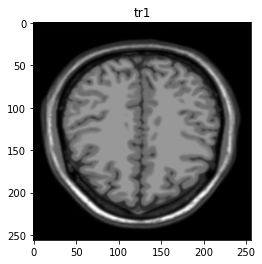

In [14]:
# Display sample image from tr1 dataset
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

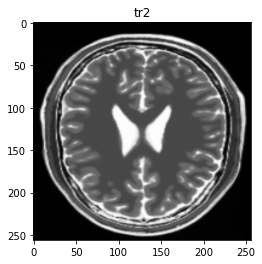

In [15]:
# Display sample image from tr2 dataset
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [16]:
# Define class for Instance Normalization, methods for downsampling and upsampling
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [17]:
# Define method for unet_generator
def unet_generator():
    down_stack = [
        downsample(64, 4, apply_norm=False), # (bs, 128, 128, 64)
        downsample(128, 4, apply_norm=True), # (bs, 64, 64, 128)
        downsample(256, 4, apply_norm=True), # (bs, 32, 32, 256)
        downsample(512, 4, apply_norm=True), # (bs, 16, 16, 512)
        downsample(512, 4, apply_norm=True), # (bs, 8, 8, 512)
        downsample(512, 4, apply_norm=True), # (bs, 4, 4, 512)
        downsample(512, 4, apply_norm=True), # (bs, 2, 2, 512)
        downsample(512, 4, apply_norm=True)  # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, apply_dropout=False), # (bs, 16, 16, 1024)
        upsample(256, 4, apply_dropout=False), # (bs, 32, 32, 512)
        upsample(128, 4, apply_dropout=False), # (bs, 64, 64, 256)
        upsample(64, 4, apply_dropout=False), # (bs, 128, 128, 128)
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', 
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, OUTPUT_CHANNELS])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
# Instantiate g and f unet_generators
generator_g = unet_generator()
generator_f = unet_generator()

In [19]:
# Define discriminator method
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, OUTPUT_CHANNELS], name='input_image')
    x = inp
    down1 = downsample(64, 4, apply_norm=False)(x)   # (bs, 128, 128, 64)
    down2 = downsample(128, 4, apply_norm=True)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4, apply_norm=True)(down2) # (bs, 32, 32, 256)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer

In [20]:
# Instantiate x and y discriminators for classifying tr1 and tr2 real vs fake images
discriminator_x = discriminator()
discriminator_y = discriminator()

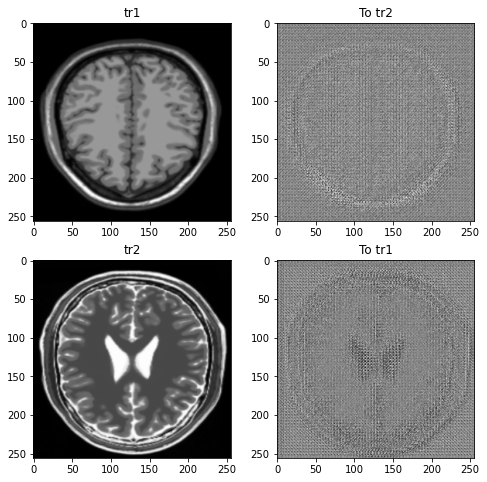

In [21]:
# Check the generator outputs for sample images
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [22]:
# Define Lambda parameter
LAMBDA = 5

In [23]:
# Define loss object uisng BinaryCrossEntropy
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
# Define method to evaluate discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real),real) #write your code here
    generated_loss = loss_obj(tf.zeros_like(generated),generated)  #write your code here
    total_disc_loss = real_loss + generated_loss #write your code here
    return total_disc_loss * 0.5

In [25]:
# Define method to evaluate generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [26]:
# Define method to evaluate cycle loss
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #write your code here
    return LAMBDA * loss1

In [27]:

# Define method to evaluate identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [28]:
# Define optimizer hyper parameters and optimizers for generators and discriminators
LEARNING_RATE=2e-4
BETA_1=0.5
BETA_2=0.999
EPSILON=1e-06

generator_g_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)
generator_f_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)

discriminator_x_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)
discriminator_y_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)

In [29]:
# Define number of epochs
EPOCHS = 3000

In [30]:
# Define checkpoint manager to save model(s) weights
checkpoint_path = "trained_models/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [31]:
# Define lists for plotting generator and discriminator losses
g_loss_per_epoch=[]
d_loss_per_epoch=[]

In [32]:
# Define generate_images method to predict output from models and stores losses
def generate_images(model, test_input, expected_output,epoch=-1,imprint=False):
    prediction = model(test_input)
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    if epoch != -1:
        g = generator_loss(prediction[0])
        d = discriminator_loss(test_input[0], prediction[0])
        g_loss_per_epoch.append(g.numpy())
        d_loss_per_epoch.append(d.numpy())
        print('Epoch :',epoch,'Generator Loss :',g.numpy(), ' Discriminator loss :',d.numpy())
    if imprint:
        plt.figure(figsize=(10, 10))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
            plt.axis('off')
        plt.show()

In [33]:
# Define train step to train generator and discriminator models
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x)
        cycled_x = generator_f(fake_y)

        fake_x = generator_f(real_y)
        cycled_y = generator_g(fake_x)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x)
        same_y = generator_g(real_y)

        disc_real_x = discriminator_x(real_x)
        disc_real_y = discriminator_y(real_y)

        disc_fake_x = discriminator_x(fake_x)
        disc_fake_y = discriminator_y(fake_y)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
    
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Epoch : 0 Generator Loss : 0.9296899  Discriminator loss : 0.7698253
Epoch : 1 Generator Loss : 0.9630606  Discriminator loss : 0.7569982
Epoch : 2 Generator Loss : 0.9773879  Discriminator loss : 0.75237304
Epoch : 3 Generator Loss : 0.9787779  Discriminator loss : 0.75312036
Epoch : 4 Generator Loss : 0.9646642  Discriminator loss : 0.7589681
Epoch : 5 Generator Loss : 0.9726566  Discriminator loss : 0.7614923
Epoch : 6 Generator Loss : 0.98014116  Discriminator loss : 0.7565812
Epoch : 7 Generator Loss : 0.9779979  Discriminator loss : 0.7578983
Epoch : 8 Generator Loss : 0.9685297  Discriminator loss : 0.7602818
Epoch : 9 Generator Loss : 0.95364493  Discriminator loss : 0.76709044
Epoch : 10 Generator Loss : 0.9642417  Discriminator loss : 0.76155484
Epoch : 11 Generator Loss : 0.96795744  Discriminator loss : 0.7641615
Epoch : 12 Generator Loss : 0.9645978  Discriminator loss : 0.7631766
Epoch : 13 Generator Loss : 0.9648802  Discriminator loss : 0.7636312
Epoch : 14 Generator Lo

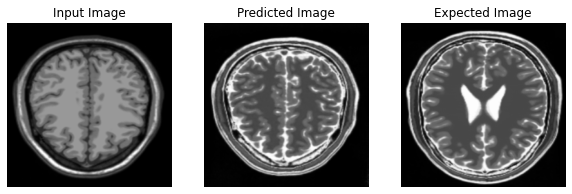

Saving checkpoint for epoch 599 at trained_models/ckpt-1
Epoch : 600 Generator Loss : 0.98085564  Discriminator loss : 0.76089996
Epoch : 601 Generator Loss : 0.9798628  Discriminator loss : 0.76125234
Epoch : 602 Generator Loss : 0.97936225  Discriminator loss : 0.76160866
Epoch : 603 Generator Loss : 0.979962  Discriminator loss : 0.7609173
Epoch : 604 Generator Loss : 0.98067856  Discriminator loss : 0.760914
Epoch : 605 Generator Loss : 0.9800634  Discriminator loss : 0.76113933
Epoch : 606 Generator Loss : 0.98130214  Discriminator loss : 0.76073146
Epoch : 607 Generator Loss : 0.98095584  Discriminator loss : 0.76071995
Epoch : 608 Generator Loss : 0.98024654  Discriminator loss : 0.76142675
Epoch : 609 Generator Loss : 0.9797156  Discriminator loss : 0.7615702
Epoch : 610 Generator Loss : 0.9803839  Discriminator loss : 0.7612746
Epoch : 611 Generator Loss : 0.9806483  Discriminator loss : 0.76109254
Epoch : 612 Generator Loss : 0.979466  Discriminator loss : 0.76139987
Epoch : 

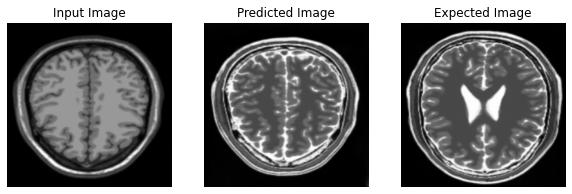

Saving checkpoint for epoch 1199 at trained_models/ckpt-2
Epoch : 1200 Generator Loss : 0.97921515  Discriminator loss : 0.7616215
Epoch : 1201 Generator Loss : 0.9765343  Discriminator loss : 0.7626351
Epoch : 1202 Generator Loss : 0.9801037  Discriminator loss : 0.7611364
Epoch : 1203 Generator Loss : 0.9791314  Discriminator loss : 0.7616269
Epoch : 1204 Generator Loss : 0.97793734  Discriminator loss : 0.7621136
Epoch : 1205 Generator Loss : 0.97817326  Discriminator loss : 0.76191545
Epoch : 1206 Generator Loss : 0.9789871  Discriminator loss : 0.7615565
Epoch : 1207 Generator Loss : 0.980403  Discriminator loss : 0.7610238
Epoch : 1208 Generator Loss : 0.9789859  Discriminator loss : 0.76157224
Epoch : 1209 Generator Loss : 0.98006123  Discriminator loss : 0.7612231
Epoch : 1210 Generator Loss : 0.9807869  Discriminator loss : 0.7606381
Epoch : 1211 Generator Loss : 0.979601  Discriminator loss : 0.76122266
Epoch : 1212 Generator Loss : 0.9808318  Discriminator loss : 0.7609307
E

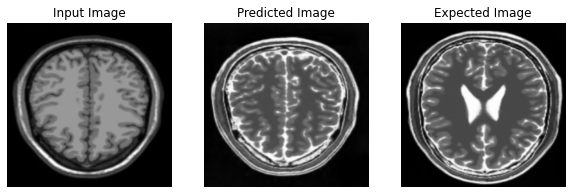

Saving checkpoint for epoch 1799 at trained_models/ckpt-3
Epoch : 1800 Generator Loss : 0.9735695  Discriminator loss : 0.7609162
Epoch : 1801 Generator Loss : 0.9723075  Discriminator loss : 0.76157963
Epoch : 1802 Generator Loss : 0.9717258  Discriminator loss : 0.76182675
Epoch : 1803 Generator Loss : 0.9723897  Discriminator loss : 0.7613507
Epoch : 1804 Generator Loss : 0.97375906  Discriminator loss : 0.7611846
Epoch : 1805 Generator Loss : 0.9734533  Discriminator loss : 0.76129985
Epoch : 1806 Generator Loss : 0.9724026  Discriminator loss : 0.7613828
Epoch : 1807 Generator Loss : 0.9728633  Discriminator loss : 0.761465
Epoch : 1808 Generator Loss : 0.97245955  Discriminator loss : 0.76121444
Epoch : 1809 Generator Loss : 0.97293866  Discriminator loss : 0.76128185
Epoch : 1810 Generator Loss : 0.9722596  Discriminator loss : 0.7610226
Epoch : 1811 Generator Loss : 0.9724388  Discriminator loss : 0.76129436
Epoch : 1812 Generator Loss : 0.97393954  Discriminator loss : 0.76113

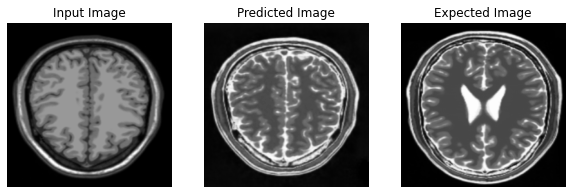

Saving checkpoint for epoch 2399 at trained_models/ckpt-4
Epoch : 2400 Generator Loss : 0.9637824  Discriminator loss : 0.7633726
Epoch : 2401 Generator Loss : 0.96366125  Discriminator loss : 0.7629615
Epoch : 2402 Generator Loss : 0.9649288  Discriminator loss : 0.7627897
Epoch : 2403 Generator Loss : 0.96391165  Discriminator loss : 0.7633461
Epoch : 2404 Generator Loss : 0.9648047  Discriminator loss : 0.7626851
Epoch : 2405 Generator Loss : 0.9626508  Discriminator loss : 0.76340175
Epoch : 2406 Generator Loss : 0.9630943  Discriminator loss : 0.763418
Epoch : 2407 Generator Loss : 0.9625379  Discriminator loss : 0.7636472
Epoch : 2408 Generator Loss : 0.9643633  Discriminator loss : 0.76283616
Epoch : 2409 Generator Loss : 0.96396774  Discriminator loss : 0.76286364
Epoch : 2410 Generator Loss : 0.9642478  Discriminator loss : 0.7633943
Epoch : 2411 Generator Loss : 0.96346116  Discriminator loss : 0.7634826
Epoch : 2412 Generator Loss : 0.9645066  Discriminator loss : 0.76285195

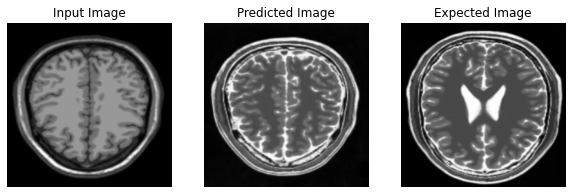

Saving checkpoint for epoch 2999 at trained_models/ckpt-5


In [34]:
# Train the models for pre-defined number of epochs
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):       
        train_step(image_x, image_y)
    if (epoch+1) % (EPOCHS/5) == 0:
        generate_images(generator_g, sample_tr1, sample_tr2,epoch,imprint=True)
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)
    else:
        generate_images(generator_g, sample_tr1, sample_tr2,epoch,imprint=False)
                                                      

In [35]:
# Print the time taken for end to end execution
print('Time taken for execution :',round((time.time() - start_time)/60),'minutes')

Time taken for execution : 505 minutes


In [36]:
# Only uncomment below line and use to delete previous trained models weights, if required
#!rm -rf trained_models

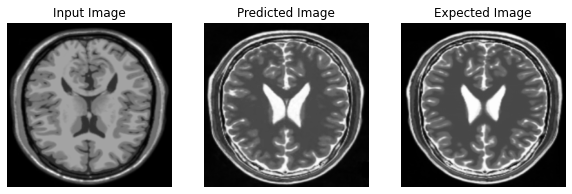

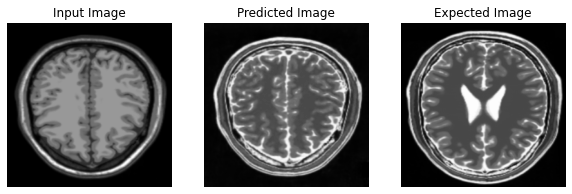

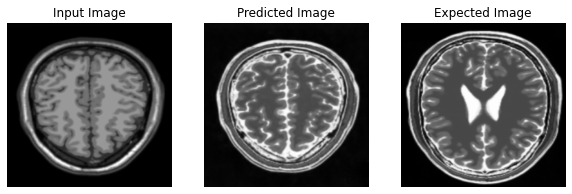

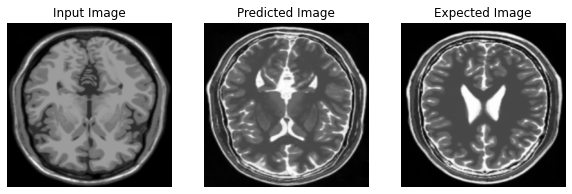

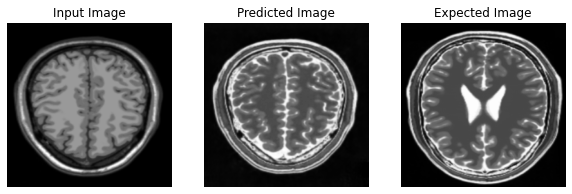

In [37]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2,imprint=True)

Text(0, 0.5, 'Loss')

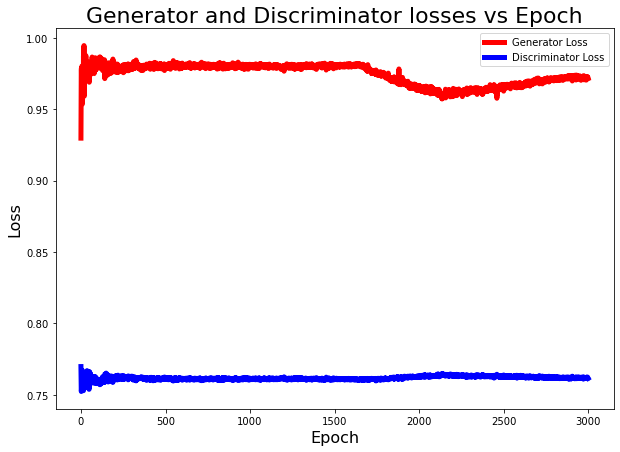

In [38]:
# Plot the generator and discriminator losses
epochs_list=list(range(EPOCHS))
plt.figure(figsize=(10,7))
plt.plot(epochs_list, g_loss_per_epoch, color='red',label='Generator Loss', linewidth=5, markersize=12)
plt.plot(epochs_list, d_loss_per_epoch, color='blue',label='Discriminator Loss', linewidth=5, markersize=12)
plt.legend()
plt.title('Generator and Discriminator losses vs Epoch', fontsize=22)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)